In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, dense_diff_pool
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity

import numpy as np
import pandas as pd
from pytorch_lightning.utilities.seed import seed_everything
from scipy.spatial.distance import cdist
from sympy import to_dnf, lambdify
from sklearn.metrics.cluster import homogeneity_score, completeness_score

import clustering_utils
import data_utils
import lens_utils
import model_utils
import persistence_utils
import visualisation_utils

In [3]:
# constants
DATASET_NAME = "BA_Grid"
MODEL_NAME = f"GCN for {DATASET_NAME}"
NUM_CLASSES = 2
K = 10

TRAIN_TEST_SPLIT = 0.8

NUM_HIDDEN_UNITS = 10
EPOCHS = 3000
LR = 0.001

RANDOM_STATE = 0

NUM_NODES_VIEW = 5
NUM_EXPANSIONS = 4

LAYER_NUM = 3
LAYER_KEY = "conv3"

visualisation_utils.set_rc_params()

In [4]:
# model definition
class GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes):
        super(GCN, self).__init__()
        
        self.conv0 = GCNConv(num_in_features, num_hidden_features)
        self.conv1 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv3 = GCNConv(num_hidden_features, num_hidden_features)
#         self.conv4 = GCNConv(num_hidden_features, num_hidden_features)
                
        # linear layers
        self.lens = torch.nn.Sequential(te.nn.EntropyLinear(num_hidden_features, 1, n_classes=num_classes))

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        
#         x = self.conv4(x, edge_index)
#         x = F.leaky_relu(x)
                
        self.gnn_embedding = x
        
#         x = F.softmax(x, dim=-1)
#         x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
        x = torch.sigmoid(x)
        x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
        concepts = x
        
        x = self.lens(x)
                
        return concepts, x.squeeze(-1)

In [5]:
def run_experiment(seed, path):
    config = {'seed': seed,
                       'dataset_name': DATASET_NAME,
                       'model_name': MODEL_NAME,
                       'num_classes': NUM_CLASSES,
                       'k': K,
                       'train_test_split': TRAIN_TEST_SPLIT,
                       'num_hidden_units': NUM_HIDDEN_UNITS,
                       'epochs': EPOCHS,
                       'lr': LR,
                       'num_nodes_view': NUM_NODES_VIEW,
                       'num_expansions': NUM_EXPANSIONS,
                       'layer_num': LAYER_NUM,
                       'layer_key': LAYER_KEY
                      }
        
    # load data
    G, labels = data_utils.load_syn_data(DATASET_NAME)
    data = data_utils.prepare_syn_data(G, labels, TRAIN_TEST_SPLIT)

    # model training
    model = GCN(data["x"].shape[1], NUM_HIDDEN_UNITS, NUM_CLASSES)
    
    # register hooks to track activation
    model = model_utils.register_hooks(model)
    
    # train 
    train_acc, test_acc, train_loss, test_loss = model_utils.train(model, data, EPOCHS, LR)
        
    visualisation_utils.plot_model_accuracy(train_acc, test_acc, MODEL_NAME, path)
    visualisation_utils.plot_model_loss(train_loss, test_loss, MODEL_NAME, path)
    
    x = data["x"]
    edges = data['edges']
    edges_t = data['edge_list'].numpy()
    y = data["y"]
    train_mask = data["train_mask"]
    test_mask = data["test_mask"]
    
    # get model activations for complete dataset
    concepts, _ = model(x, edges)
    activation = torch.squeeze(model_utils.activation_list[LAYER_KEY]).detach().numpy()
    
    # find centroids
    centroids, centroid_labels, used_centroid_labels = clustering_utils.find_centroids(activation, concepts, y)
    print(f"Number of cenroids: {len(centroids)}")
    
    # plot concept heatmaps
    visualisation_utils.plot_concept_heatmap(centroids, concepts, y, used_centroid_labels, MODEL_NAME, LAYER_NUM, path)
    
    # concept alignment
    homogeneity = homogeneity_score(y, used_centroid_labels)
    # clustering efficency
    completeness = completeness_score(y, used_centroid_labels)
    
    print(f"Concept homogeneity score: {homogeneity}")
    print(f"Concept completeness score: {completeness}")
    
    # generate explanations
    explanations = lens_utils.explain_classes(model, concepts, y, train_mask, test_mask)
    
    # plot clustering
    visualisation_utils.plot_clustering(seed, activation, y, centroids, centroid_labels, used_centroid_labels, MODEL_NAME, LAYER_NUM, path)
    
    # calculate cluster sizing
    cluster_counts = visualisation_utils.print_cluster_counts(used_centroid_labels)

    # plot samples
    sample_graphs, sample_feat = visualisation_utils.plot_samples(None, activation, y, LAYER_NUM, len(centroids), "Differential Clustering", "Raw", NUM_NODES_VIEW, edges_t, NUM_EXPANSIONS, path, concepts=centroids)
    
    # dump data
    persistence_utils.persist_experiment(config, path, 'config.z')
    persistence_utils.persist_experiment(data, path,'data.z')
    
    persistence_utils.persist_model(model, path, 'model.z')
    
    persistence_utils.persist_experiment(concepts, path, 'concepts.z')
    persistence_utils.persist_experiment(model_utils.activation_list, path, 'activation_list.z')
    persistence_utils.persist_experiment(centroids, path, 'centroids.z')
    persistence_utils.persist_experiment(centroid_labels, path, 'centroid_labels.z')
    persistence_utils.persist_experiment(used_centroid_labels, path, 'used_centroid_labels.z')
    
    concept_metrics = [('homogeneity', homogeneity), ('completeness', completeness), ('cluster_count', cluster_counts)]
    persistence_utils.persist_experiment(concept_metrics, path, 'concept_metrics.z')
    persistence_utils.persist_experiment(explanations, path, 'explanations.z')
    persistence_utils.persist_experiment(sample_graphs, path, 'sample_graphs.z')
    persistence_utils.persist_experiment(sample_feat, path, 'sample_feat.z')
    
    # clean up
    plt.close()

Global seed set to 42



START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


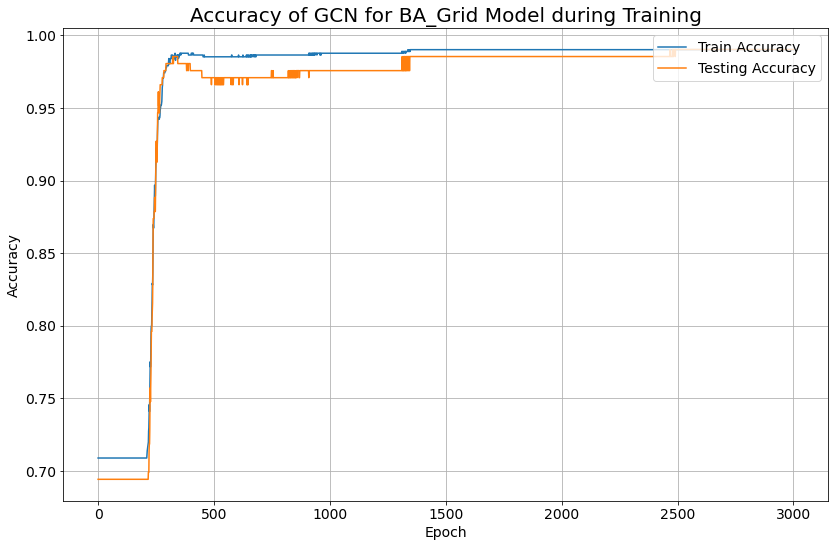

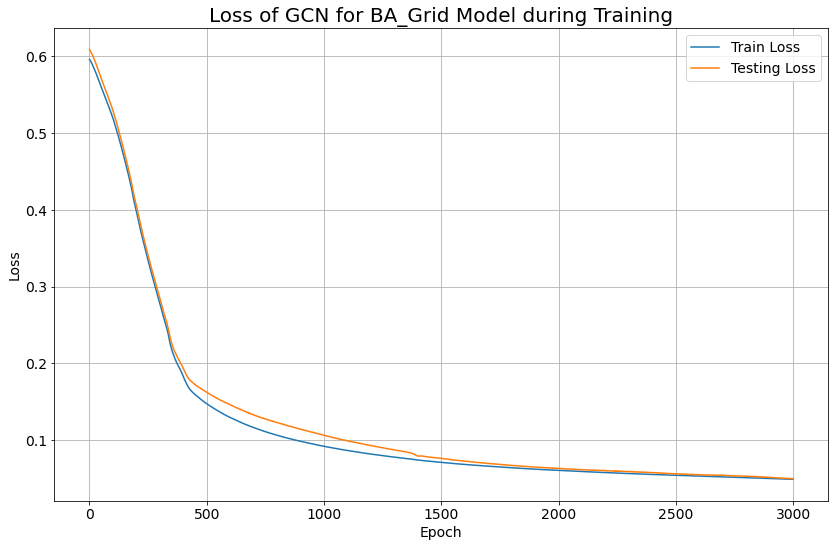

Number of cenroids: 8
Concept homogeneity score: 0.14217732045872233
Concept completeness score: 0.2643122329496402
Explanation class 0: ~feature0000000004 - acc. = 0.5843 - compl. = 1.0000
Explanation class 1: feature0000000004 - acc. = 0.5843 - compl. = 1.0000


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 1080x360 with 0 Axes>

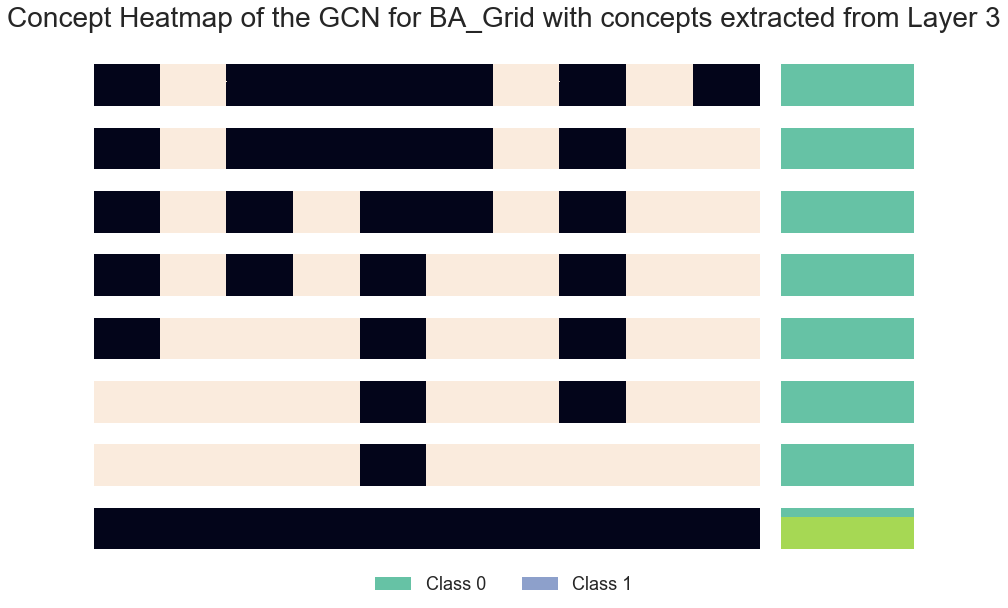

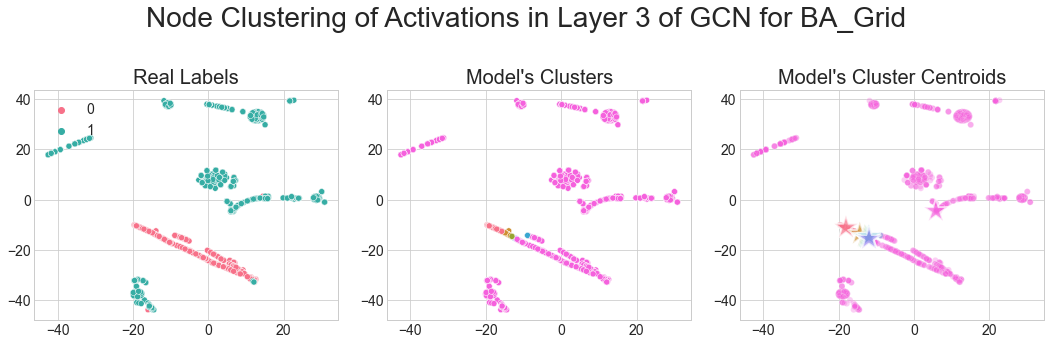

Cluster sizes by cluster id:
	Cluster 0: 40
	Cluster 1: 12
	Cluster 2: 4
	Cluster 3: 1
	Cluster 4: 1
	Cluster 5: 5
	Cluster 6: 4
	Cluster 7: 953


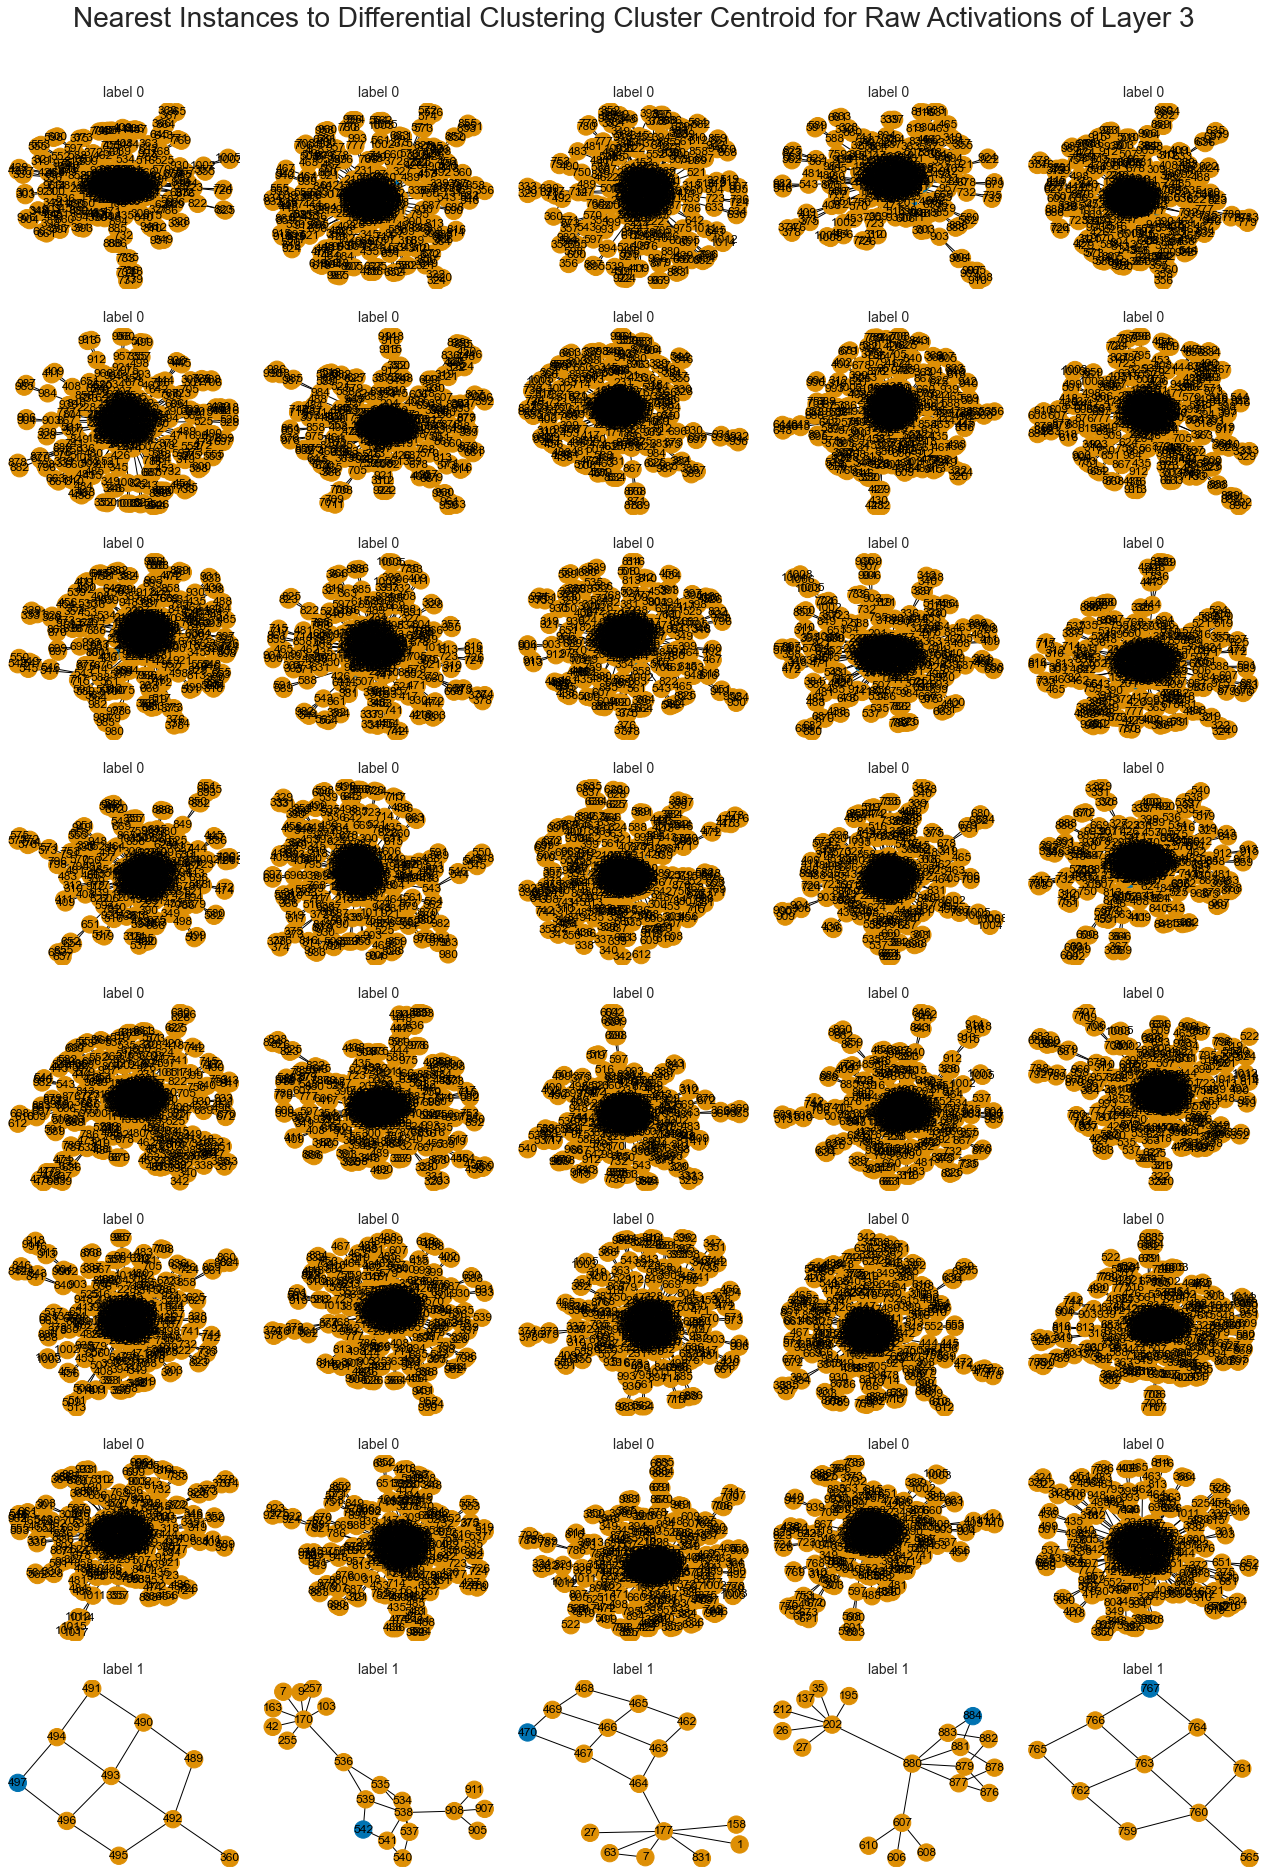

Global seed set to 19



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


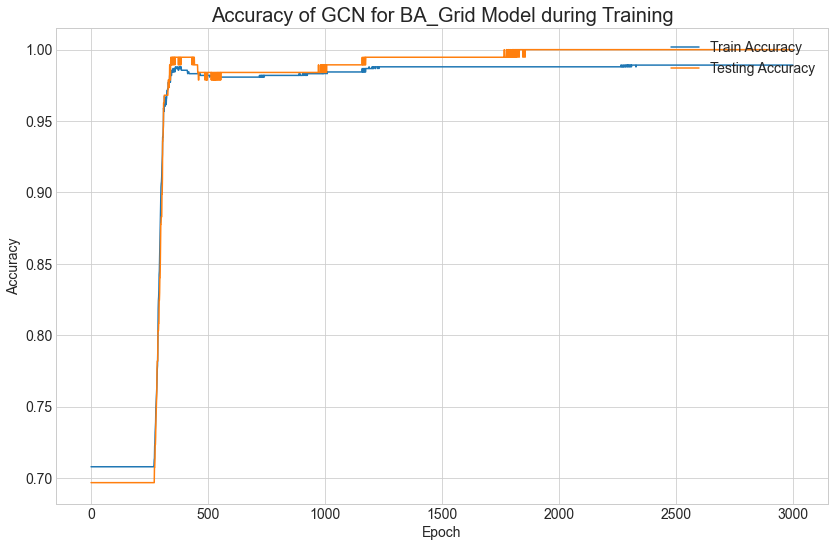

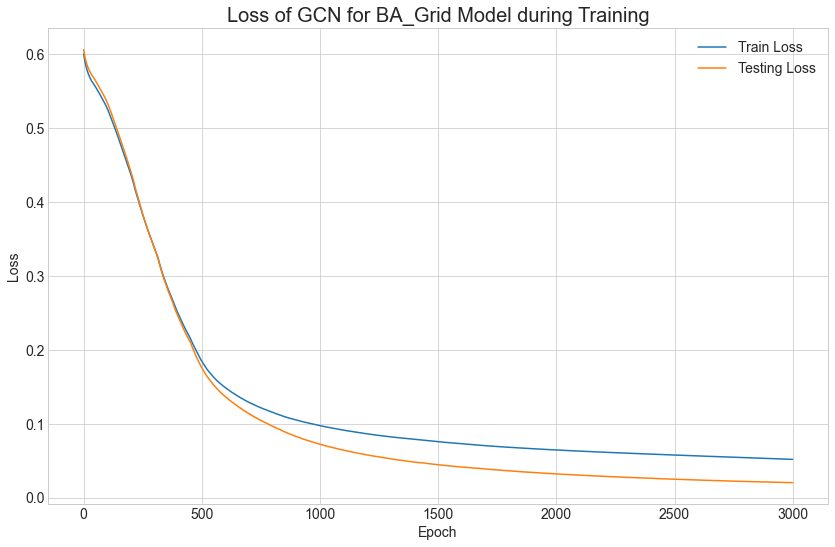

Number of cenroids: 4
Concept homogeneity score: 0.00795262557141922
Concept completeness score: 0.1620933073660914
Explanation class 0: ~feature0000000002 - acc. = 0.4107 - compl. = 1.0000
Explanation class 1: feature0000000002 - acc. = 0.4107 - compl. = 1.0000


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 1080x360 with 0 Axes>

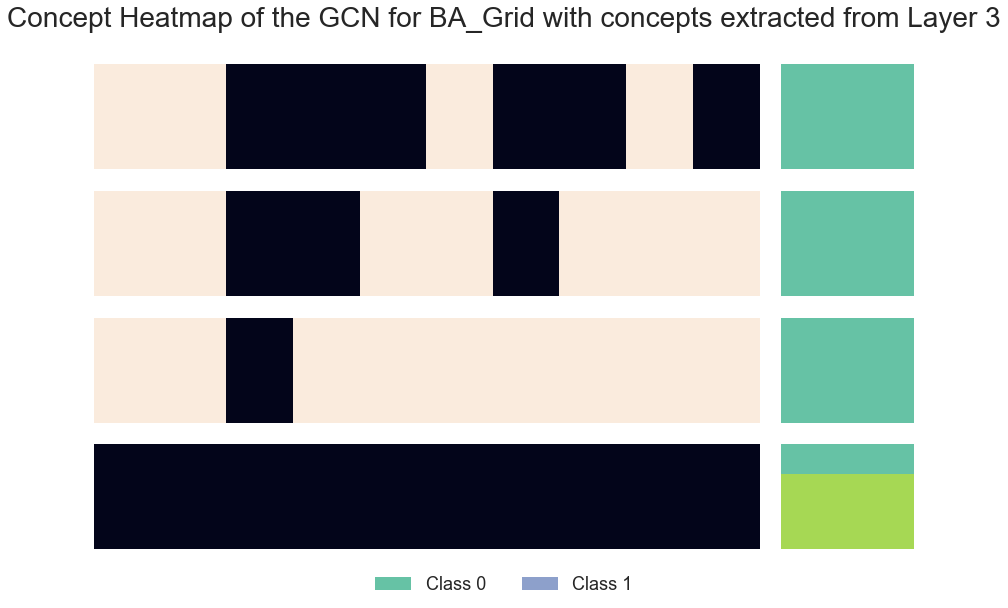

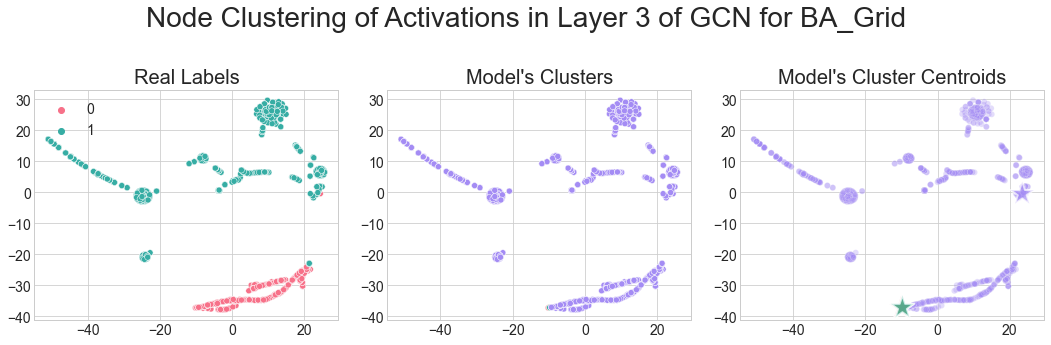

Cluster sizes by cluster id:
	Cluster 0: 2
	Cluster 1: 1
	Cluster 2: 1
	Cluster 3: 1016


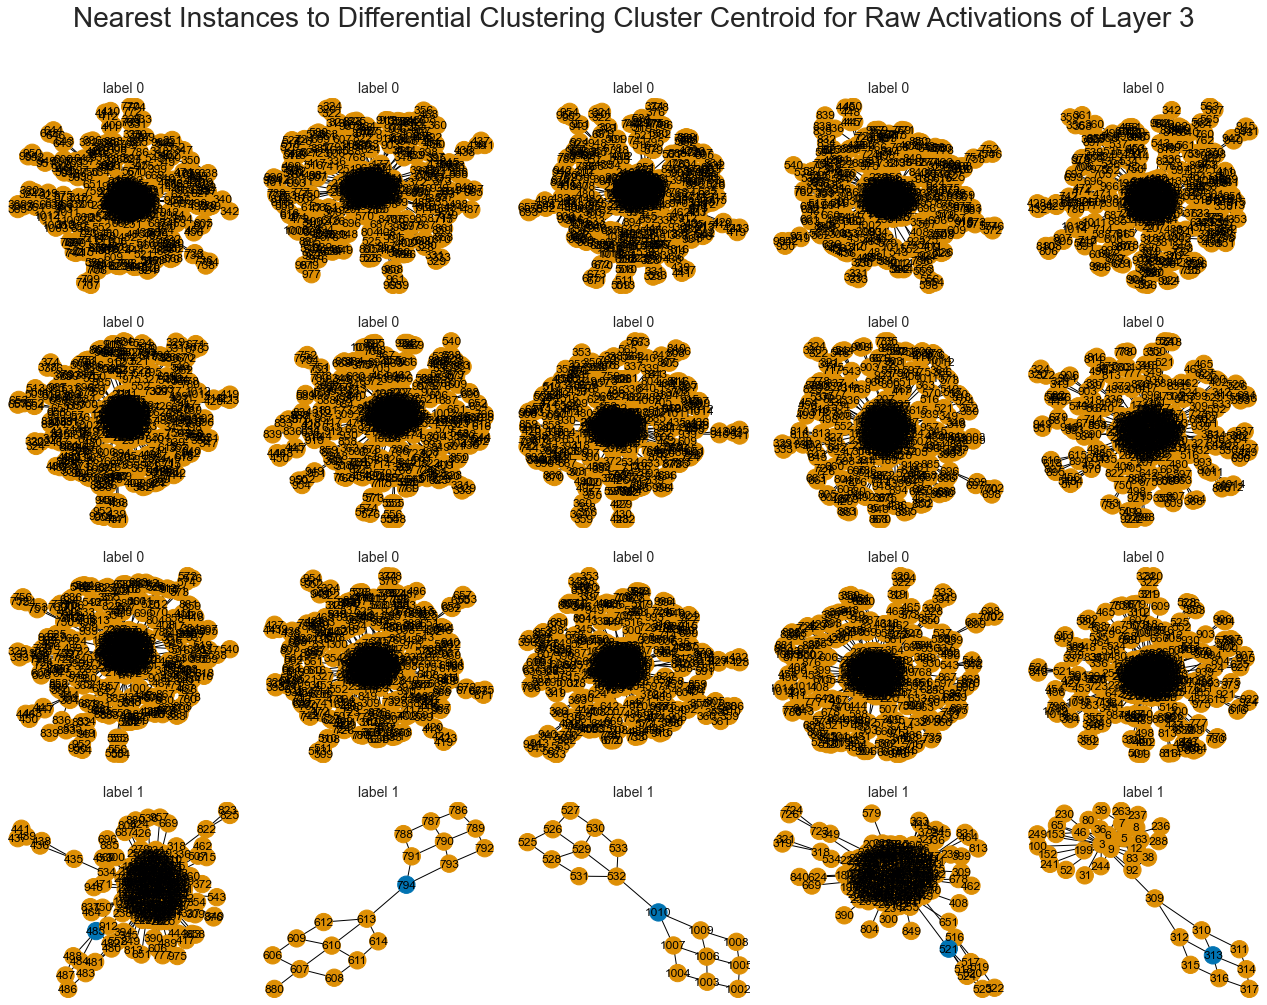

Global seed set to 76



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


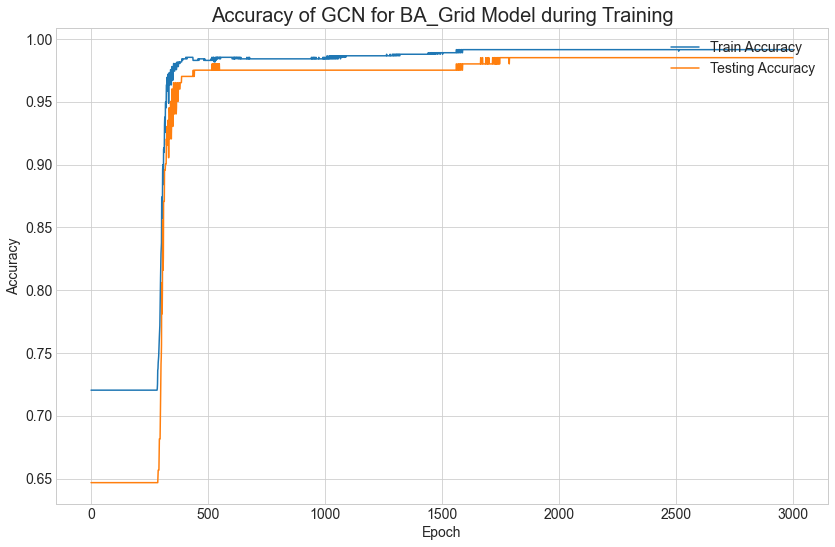

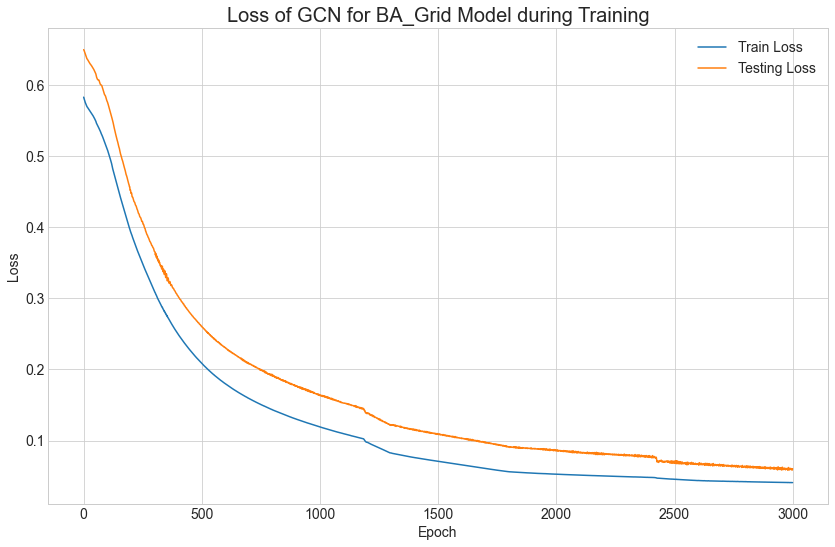

Number of cenroids: 2
Concept homogeneity score: 0.003968630768140413
Concept completeness score: 0.16950951564767675
Explanation class 0: feature0000000009 - acc. = 0.2610 - compl. = 1.0000
Explanation class 1: feature0000000006 - acc. = 0.3927 - compl. = 1.0000


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 1080x360 with 0 Axes>

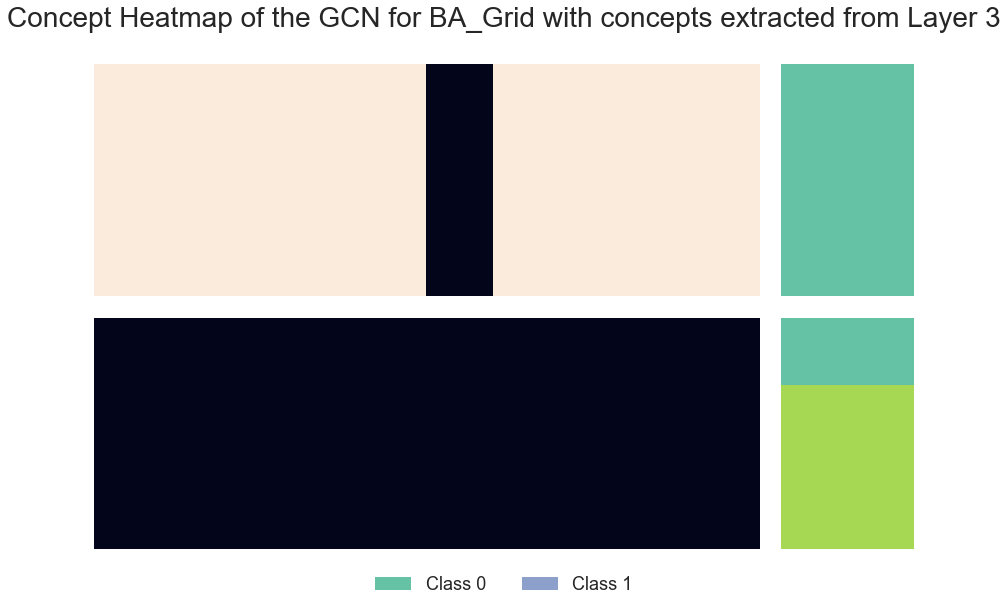

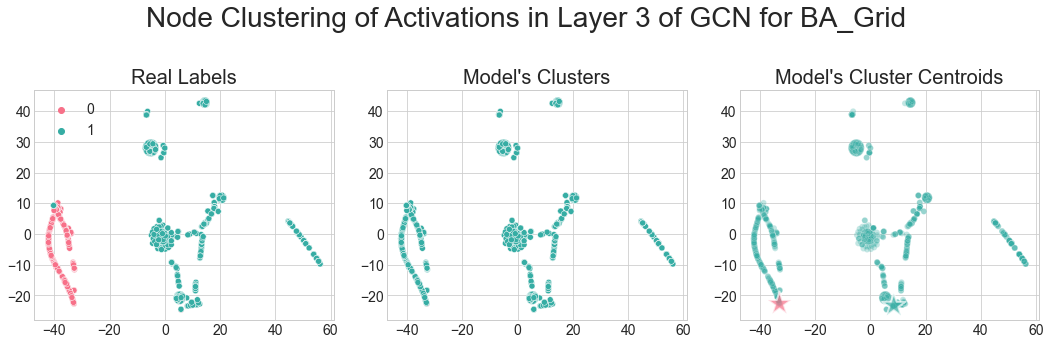

Cluster sizes by cluster id:
	Cluster 0: 2
	Cluster 1: 1018


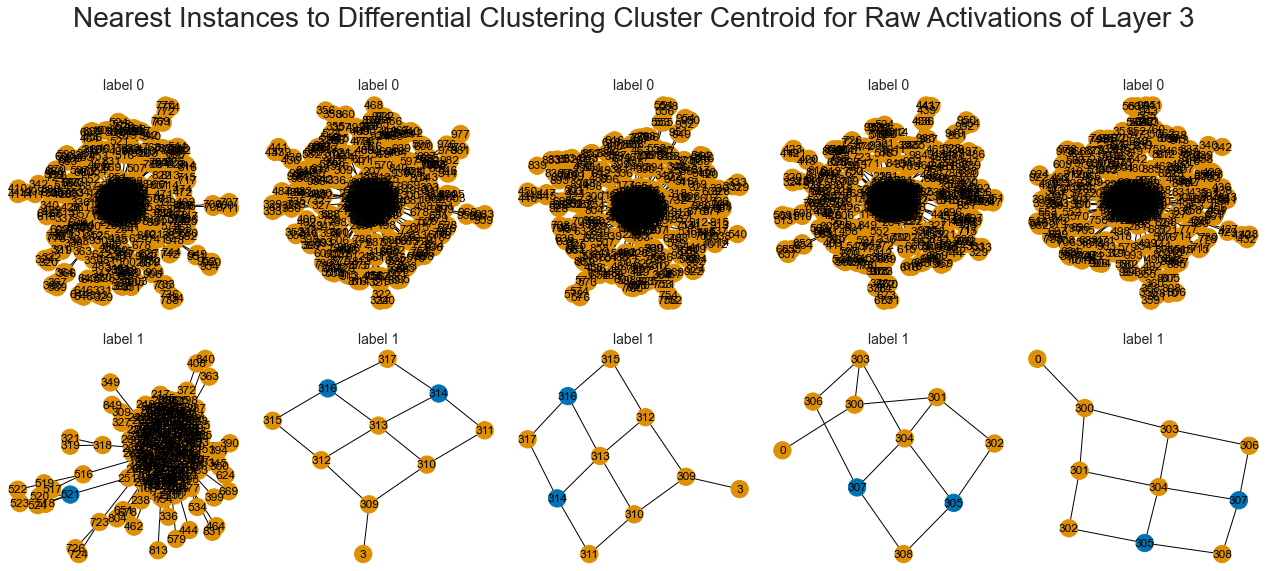

Global seed set to 58



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


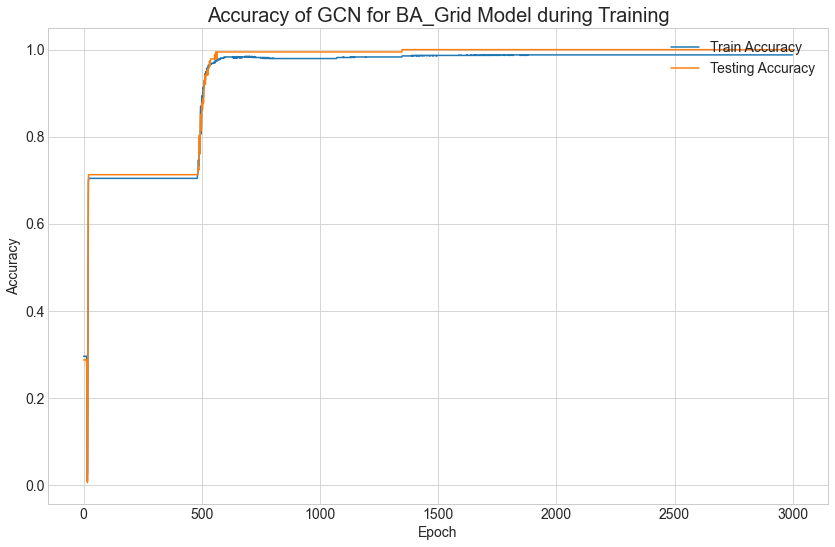

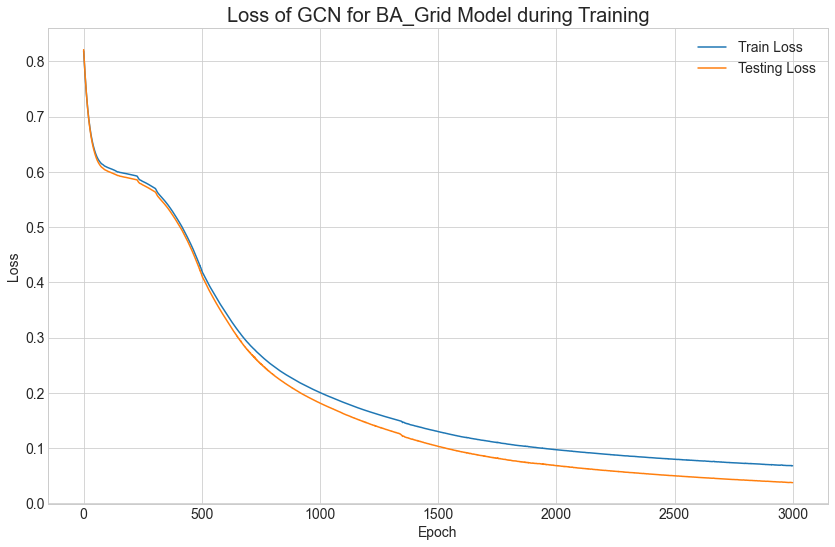

Number of cenroids: 5
Concept homogeneity score: 0.9117427992868328
Concept completeness score: 0.767864946212892
Explanation class 0: feature0000000002 - acc. = 1.0000 - compl. = 1.0000
Explanation class 1: ~feature0000000002 - acc. = 1.0000 - compl. = 1.0000


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 1080x360 with 0 Axes>

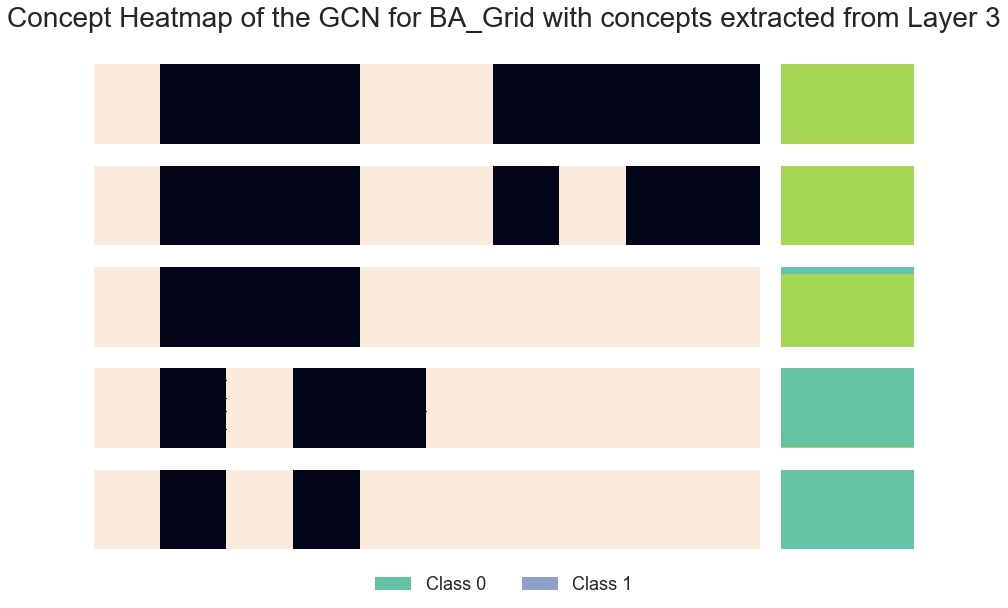

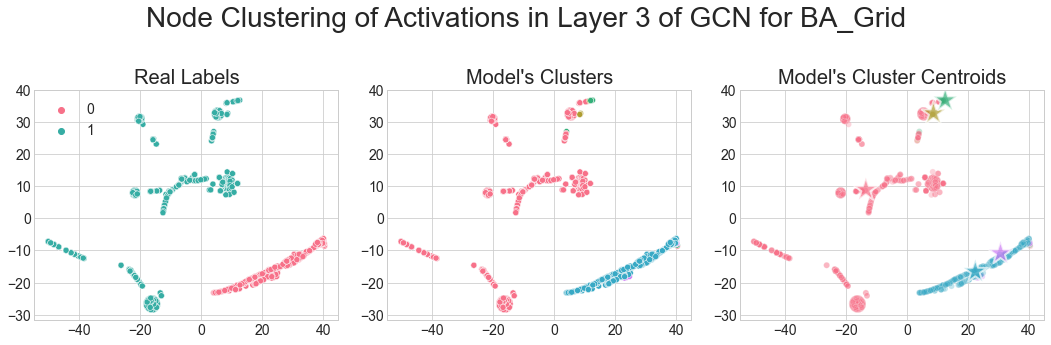

Cluster sizes by cluster id:
	Cluster 0: 709
	Cluster 1: 5
	Cluster 2: 10
	Cluster 3: 288
	Cluster 4: 8


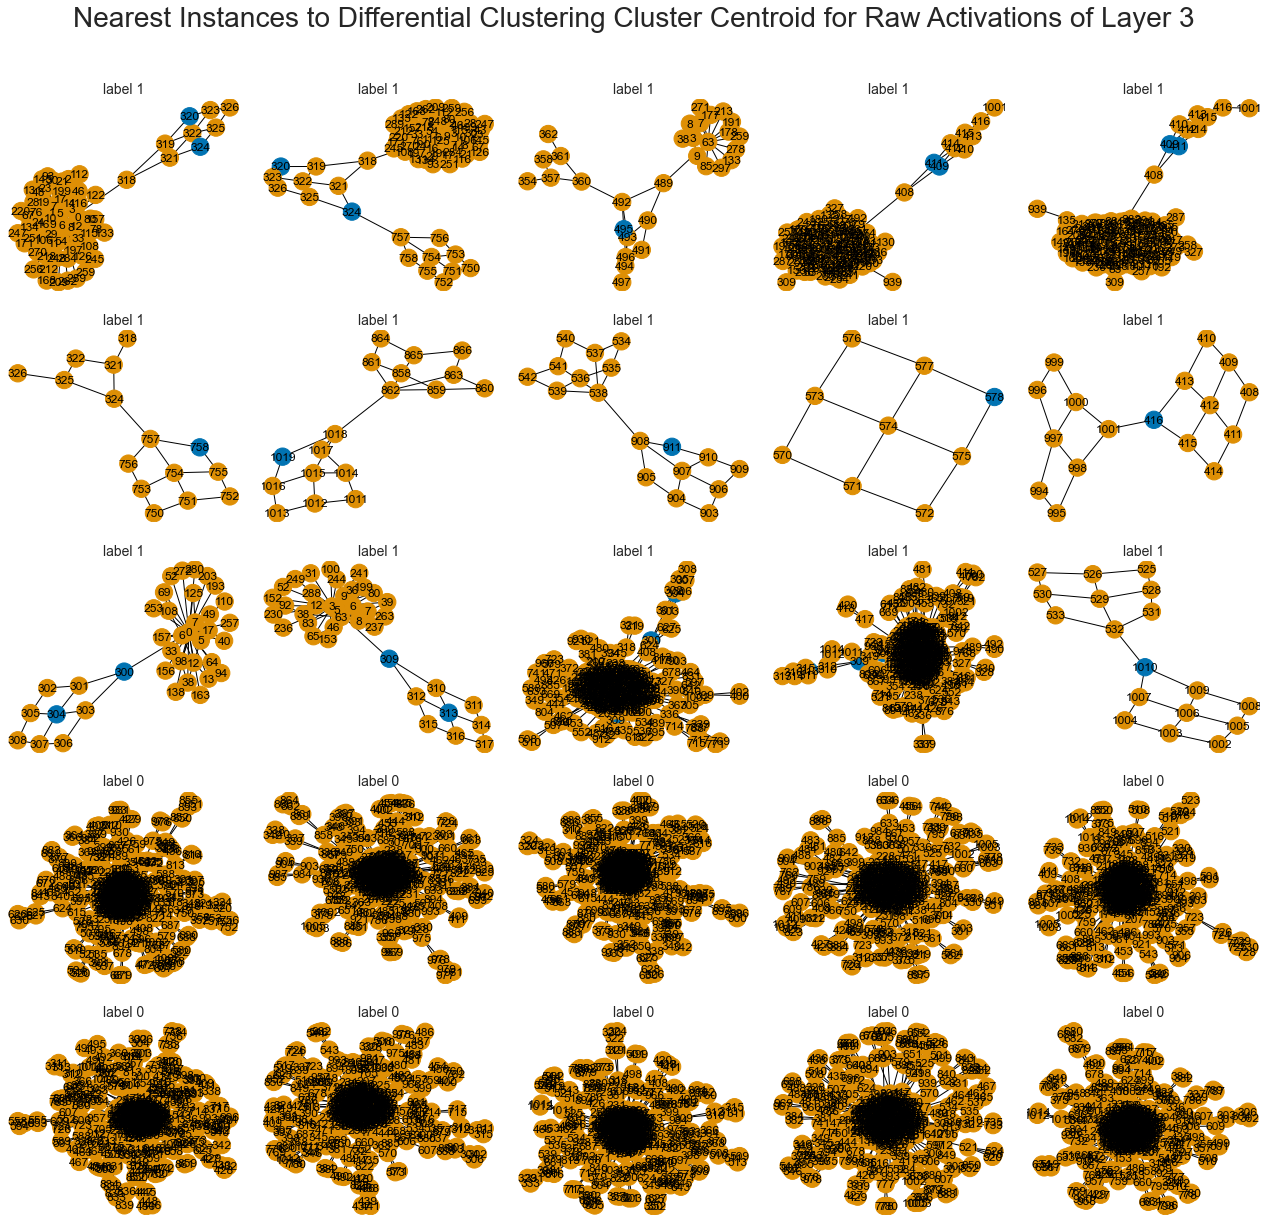

Global seed set to 92



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


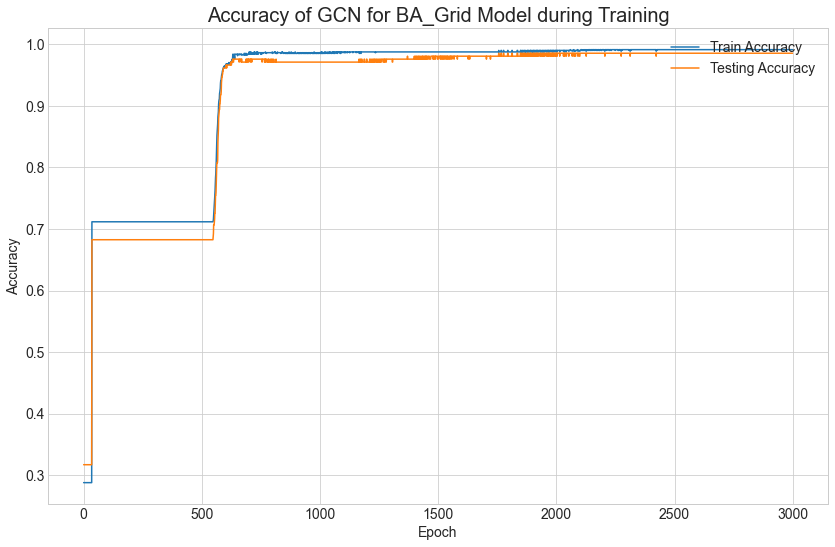

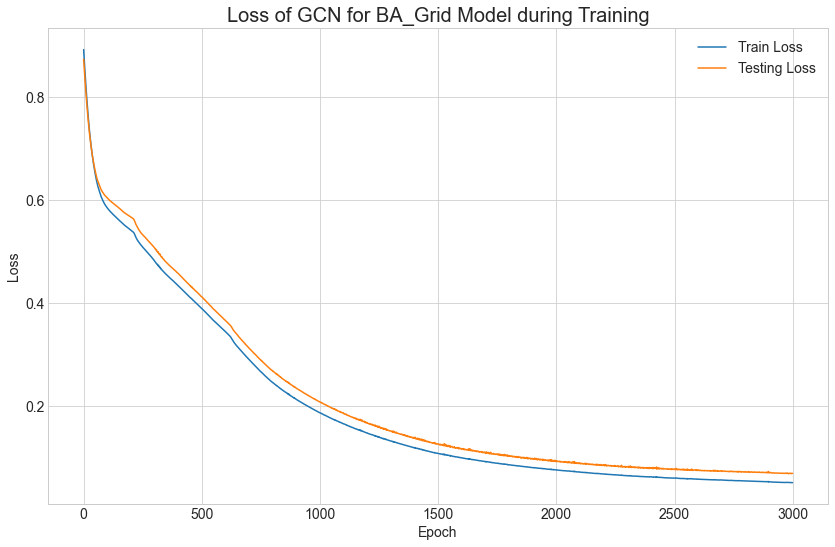

Number of cenroids: 11
Concept homogeneity score: 0.6674521913011179
Concept completeness score: 0.29491730409244976
Explanation class 0: feature0000000006 & ~feature0000000005 - acc. = 0.8436 - compl. = 2.0000
Explanation class 1: ~feature0000000006 - acc. = 0.8436 - compl. = 1.0000


/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/luciecharlottemagister/Documents/Cambridge/PhD/Projects/NEWRON_LEN/newron_len_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword a

<Figure size 1080x360 with 0 Axes>

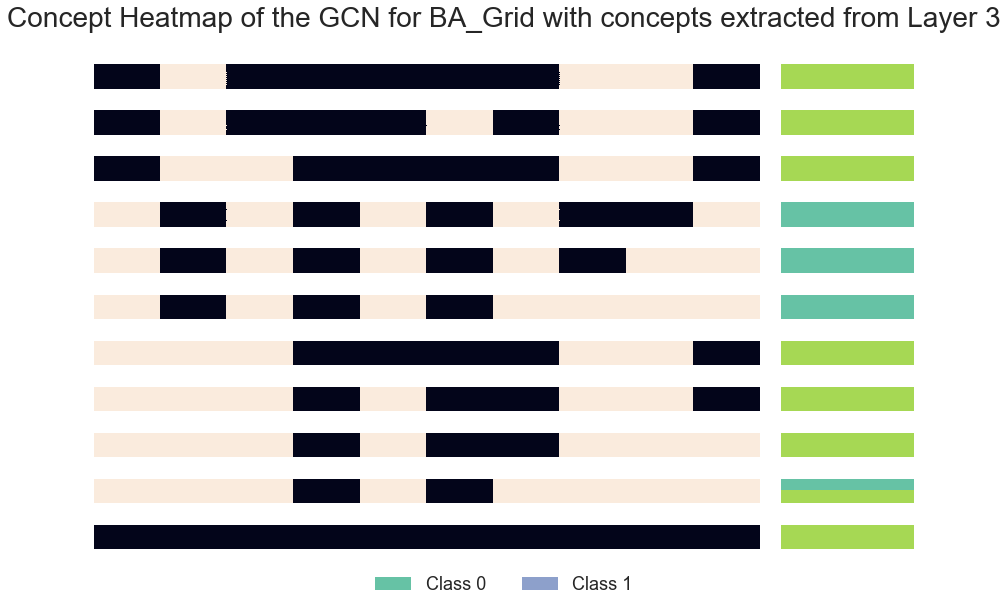

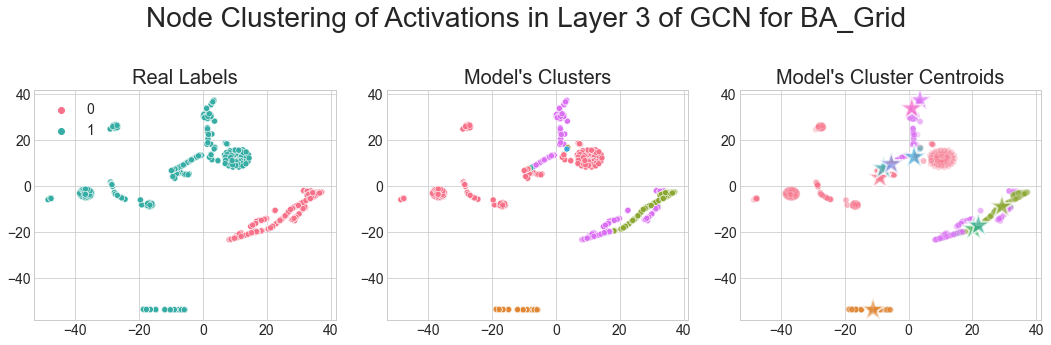

Cluster sizes by cluster id:
	Cluster 0: 453
	Cluster 1: 92
	Cluster 2: 6
	Cluster 3: 149
	Cluster 4: 6
	Cluster 5: 4
	Cluster 6: 2
	Cluster 7: 5
	Cluster 8: 5
	Cluster 9: 297
	Cluster 10: 1


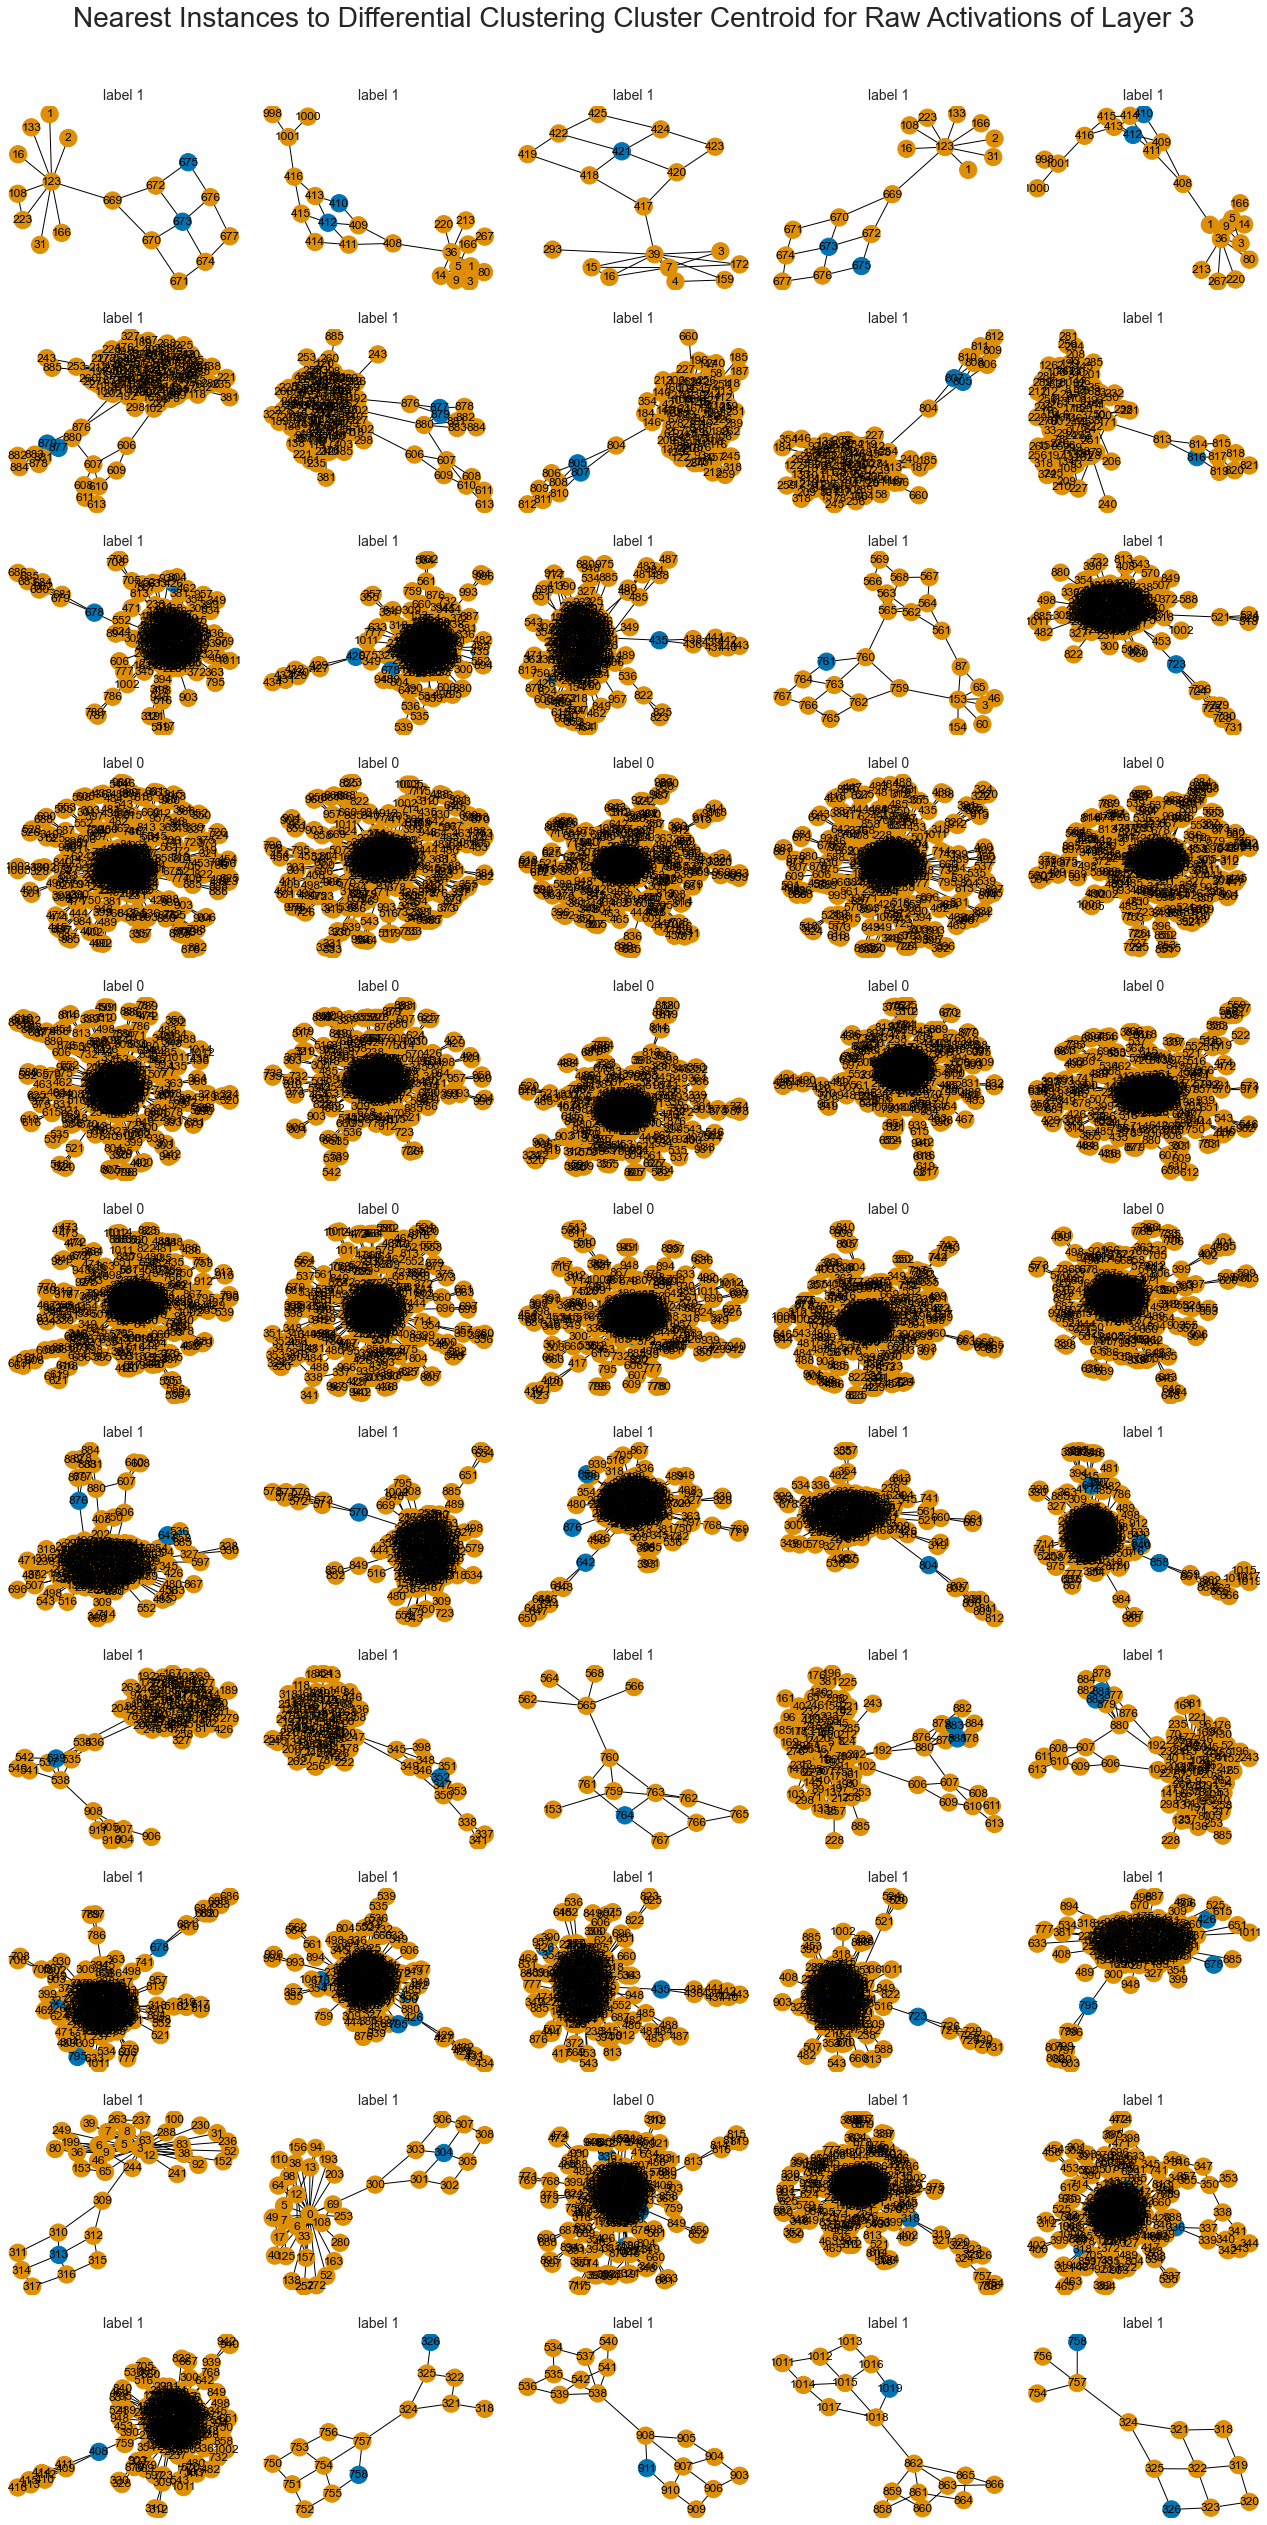


END EXPERIMENT-------------------------------------------



In [6]:
# run multiple times for confidence interval - seeds generated using Google's random number generator
random_seeds = [42, 19, 76, 58, 92]

for seed in random_seeds:
    print("\nSTART EXPERIMENT-----------------------------------------\n")
    seed_everything(seed)
    
    path = os.path.join("..", "output", DATASET_NAME + "_sigmoid_test_normalised", f"seed_{seed}")
    data_utils.create_path(path)

    run_experiment(seed, path)
    
    print("\nEND EXPERIMENT-------------------------------------------\n")